![Causal loop diagram][loops]

1. There is a common saying : the past does not define our future
2. Previously I patched together a simple trend analysis model of passenger throughput based on past observations of similar data (to the availability of publicly accessible data) and subsequently projecting them forward into the future with a confidence interval. 
3. It is an naive assumption that there are no other factors involved, a simplistic understanding of growth.
4. In the real world there are numerous complex interacting causes and effects (ie more growth may led to subsequently less growth if not managed well). In order to understand such complex relationships , I shall utilise casual loop diagrams.
5. Above shows an initial causal loop sketch for changi airport strung together manually in powerpoint. Blue indicates positive relationships, red implies a inverse relatioship.
6. The relationships are subsequently coded into a graph database for my further analysis

[loops]: https://wykeith.github.io/images/CL-Slide1.JPG "Causal loop diagram of Changi Airport"

In [27]:
pos_relationship = [
    ['Airport Tax','Infrastructure Investment'],
    ['Passenger Volume','Airport Tax'],
    ['Infrastructure Investment','Excess Terminal Capacity'],
    ['Excess of Demand for Air Travel','Air-ticket Price'],
    ['Quality of Service','Air Travel (Demand)'],
    ['Local Population','Air Travel (Demand)'],
    ['Excess Terminal Capacity','Quality of Service'],
    ['Excess Terminal Capacity','Attractiveness of Terminal'],
    ['Air Travel (Demand)','Passenger Volume'],
    ['Passenger Volume','Airport Tax'],
    ['Passenger Volume','Excess of Demand for Air Travel'],
    ['Passenger Volume','Growth of Region'],
    ['Attractiveness of Terminal','New Entrants'],
    ['Air Travel Services (Supply)','Avaliable Destinations'],
    ['Avaliable Destinations','Excess of Demand for Air Travel'],
    ['Growth of Region','Avaliable Destinations'],
    ['New Entrants','Number of Airplanes'],
    ['New Entrants','Quality of Service'],
    ['Number of Airplanes','Air Travel Services (Supply)']
]

neg_relationship = [
    ['Air-ticket Price','Air Travel (Demand)'],
    ['Air Travel Services (Supply)','Excess Terminal Capacity'],
    ['Air Travel Services (Supply)','Excess of Demand for Air Travel'],
    ['Excess of Demand for Air Travel','Quality of Service']
]

for relation in pos_relationship:
    re = Relationship(Node('item', title=relation[0]), "S", Node('item', title=relation[1]), Direction=+1)
    graph.merge(re)

for relation in neg_relationship:
    re = Relationship(Node('item', title=relation[0]), "O", Node('item', title=relation[1]), Direction=-1)
    graph.merge(re)

![Causal loop diagram][neo4j]

[neo4j]: https://wykeith.github.io/images/CL-Slide2.JPG "Causal loop diagram of Changi Airport"

## Longest chain in the network
![Causal loop diagram][slide3]
Just for fun , I wanted to know what is the longest path I can walk, not re-visiting any nodes and arriving back to the same place without changing direction of the relationships. 11 nodes is the longest discovered by the graph query.

[slide3]: https://wykeith.github.io/images/CL-Slide3.png "Longest loop Chain"

## Look for a reinforcing or virtuous loop
![Causal loop diagram][slide4]

When there is an investment in airport infrastucture it leads to increase in airport capacity which then improves services levels. Better service levels brings in more passengers and hence increase in revenue for the airport to improve infrastructure. Improvement in airport infrastructre will also attract new airlines to fly through, this increases competition which will also bring up service levels to attact more customers 

[slide4]: https://wykeith.github.io/images/CL-Slide4.png "Virtuous loop Chain"

## Then a balancing or vicious loop
![Causal loop diagram][slide5]

On the other hand , increasing passenger volumes will lead to crowding of the airports bringing down the excess demand for travelling and the lowering of quality of service provided. This provides a counter-balance to the revenue/investment loop above.

[slide5]: https://wykeith.github.io/images/CL-Slide5.png "Vicious loop Chain"

## Graph analysis - Centrality

Centrality measures give us relative measures of importance in the network. There are many different centrality measures and each measures a different type of “importance. In graph theory, eigenvector centrality (also called eigencentrality) is a measure of the influence of a node in a network. It assigns relative scores to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes.

In [28]:
from igraph import Graph as IGraph

query = '''
MATCH (c1)-[r]->(c2)
RETURN ID(c1), ID(c2), r.Direction AS weight
'''

ig = IGraph.TupleList(graph.run(query), weights=True)

In [29]:
#pg = ig.personalized_pagerank(niter=10000)
pg = ig.eigenvector_centrality()
pgvs = []
for p in zip(ig.vs, pg):
    pgvs.append({"ID": p[0]["name"], "pg": p[1]})

write_clusters_query = '''
UNWIND {nodes} AS n
MATCH (c) WHERE ID(c) = n.ID
SET c.value = n.pg
'''

graph.run(write_clusters_query, nodes=pgvs)

## Important Nodes in our Causal Loops
![Causal loop diagram][slide6]
[slide6]: https://wykeith.github.io/images/CL-Slide6.png "Centrai"

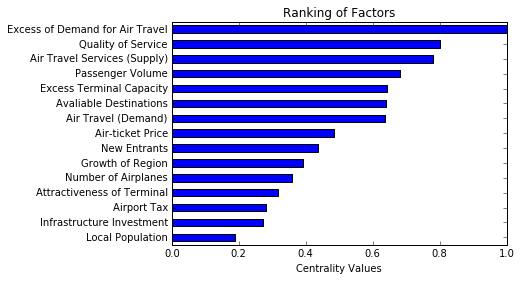

In [9]:
# Bar chart to compare the relative importance of each node
query = "MATCH (a) RETURN a.title AS title, a.value AS value"
df = pd.DataFrame(graph.data(query))

fig = plt.figure()
ax = fig.add_subplot(111)
df.sort_values(by='value', inplace=True)
df.set_index('title').value.plot(kind='barh')
ax.set_ylabel('')
ax.set_xlabel('Centrality Values')
ax.set_title('Ranking of Factors')
plt.show()

### Notes:

1. Pertaining to the development of airports , this model shows the most important factors that can influence our planning.
2. It seems that local population is not a key dominant determinant in airport planning , due to it's limited relationship with the other factors. If I create more links to the other nodes , then it's centrality value or importance will increase.
3. Casual Loops can help us to identify systemic risks or unintended effects, ie the reinforcing loop and balancing loops both impacting capacity and quality of service differently
4. Quantitative econometric models can then be built based on these diagrams, which I hope to explore futher.